In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# Load all data sources
events = pd.read_parquet('../vehicle_events_export.parquet')
matches = pd.read_parquet('../matching/matching_candidates_scored.parquet')
pois = pd.read_parquet('pois.parquet')

print(f'=== Data Loaded ===')
print(f'Events: {len(events):,} rows')
print(f'Matches: {len(matches):,} rows')
print(f'POIs: {len(pois):,} rows ({pois["event_id"].nunique():,} unique events)')

=== Data Loaded ===
Events: 16,476,198 rows
Matches: 45,366,529 rows
POIs: 242,781,869 rows (5,759,515 unique events)


In [3]:
# Select best match per departure and map to event IDs
best_matches = matches.loc[matches.groupby('d_idx')['prob'].idxmax()].copy()

# Map d_idx and f_idx to actual event IDs
id_col = 'id'
idx_to_id = events[id_col].to_dict()
best_matches['d_id'] = best_matches['d_idx'].map(idx_to_id)
best_matches['f_id'] = best_matches['f_idx'].map(idx_to_id)

print(f'Total matches: {len(best_matches):,}')
print(f'ID mapping success: {best_matches["d_id"].notna().mean()*100:.1f}%')

Total matches: 2,239,465
ID mapping success: 100.0%


In [4]:
# Filter to high confidence matches and map city
MIN_PROB = 0.5
trips = best_matches[best_matches['prob'] > MIN_PROB].copy()

# Map city from events
idx_to_city = events['city'].to_dict()
trips['city'] = trips['d_idx'].map(idx_to_city)

# Add time features (CET = UTC+1)
trips['hour'] = (pd.to_datetime(trips['d_time']).dt.hour + 1) % 24
trips['dayofweek'] = pd.to_datetime(trips['d_time']).dt.dayofweek

def get_time_phase(hour):
    if 6 <= hour < 14:
        return '6-14'
    elif 14 <= hour < 22:
        return '14-22'
    else:
        return '22-6'

trips['time_phase'] = trips['hour'].apply(get_time_phase)
trips['day_type'] = trips['dayofweek'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Filter known data quality issues: Saarbrücken 4am spike (ID resets)
saar_4am_mask = (trips['city'] == 'Saarbrücken') & (trips['hour'] == 4)
n_filtered = saar_4am_mask.sum()
trips = trips[~saar_4am_mask].copy()

print(f'High confidence trips: {len(trips):,}')
print(f'Filtered out {n_filtered:,} Saarbrücken 4am trips (ID resets)')
print(f'\nTrips by city:')
print(trips['city'].value_counts().head(10))

High confidence trips: 1,724,605
Filtered out 17,532 Saarbrücken 4am trips (ID resets)

Trips by city:
city
Stuttgart              416563
Zürich                 333260
Karlsruhe              219092
Reutlingen/Tübingen    126526
Mannheim               116528
Saarbrücken             84161
Basel                   73867
Heilbronn               52355
Ulm                     43380
Bern                    40256
Name: count, dtype: int64


In [5]:
# Exclude uninformative classes
EXCLUDE_CLASSES = ['building_other', 'public_service', 'parking', 'transportation', 'amenity', 'railway']
pois_filtered = pois[~pois['class'].isin(EXCLUDE_CLASSES)].copy()
pois_filtered['class'] = pois_filtered['class'].astype(str)

# Distance weighting function
CUTOFF = 30  # meters - flat weight below this
MAX_DIST = 100  # meters - max distance in data
MIN_WEIGHT = 0.5  # weight at max distance

def compute_weight(distance):
    return np.where(
        distance <= CUTOFF,
        1.0,
        MIN_WEIGHT + (1 - MIN_WEIGHT) * (1 - (distance - CUTOFF) / (MAX_DIST - CUTOFF))
    )

pois_filtered['weight'] = compute_weight(pois_filtered['distance_m'].values)

print(f'POIs filtered: {len(pois):,} -> {len(pois_filtered):,} rows')
print(f'Remaining classes: {pois_filtered["class"].nunique()}')

POIs filtered: 242,781,869 -> 115,602,300 rows
Remaining classes: 23


In [6]:
# Aggregate to event level and compute row proportions
weighted_counts = pois_filtered.groupby(['event_id', 'class'])['weight'].sum().unstack(fill_value=0)
weighted_counts = weighted_counts.loc[:, (weighted_counts > 0).any()]
row_proportions = weighted_counts.div(weighted_counts.sum(axis=1), axis=0)

print(f'Aggregated shape: {weighted_counts.shape}')
print(f'\nGlobal mean proportions:')
print(row_proportions.mean().sort_values(ascending=False).head(10).round(4))

Aggregated shape: (5626157, 23)

Global mean proportions:
class
residential         0.4067
public_transport    0.1013
retail              0.0990
commercial          0.0661
recreation          0.0509
sustenance          0.0493
education           0.0487
attraction          0.0397
sports              0.0292
healthcare          0.0256
dtype: float64


In [7]:
# Filter trips to those with POI data at both ends
has_origin_poi = trips['d_id'].isin(row_proportions.index)
has_dest_poi = trips['f_id'].isin(row_proportions.index)
trips = trips[has_origin_poi & has_dest_poi].copy()

print(f'Final trips with POI data: {len(trips):,}')
print(f'\nTrips by time phase (CET):')
print(trips['time_phase'].value_counts().reindex(['6-14', '14-22', '22-6']))
print(f'\nTrips by day type:')
print(trips['day_type'].value_counts())

Final trips with POI data: 1,609,072

Trips by time phase (CET):
time_phase
6-14     537708
14-22    787695
22-6     283669
Name: count, dtype: int64

Trips by day type:
day_type
Weekday    1225666
Weekend     383406
Name: count, dtype: int64


In [8]:
# Define key classes for analysis (grouped by category)
KEY_CLASSES = [
    # Living
    'residential',
    # Work
    'office', 'commercial', 'industrial',
    # Transport
    'public_transport',
    # Daily needs
    'retail', 'sustenance', 'healthcare',
    # Education
    'education',
    # Leisure
    'recreation', 'entertainment', 'sports', 'attraction'
]
available_classes = [c for c in KEY_CLASSES if c in row_proportions.columns]

print(f'Analysis classes ({len(available_classes)}): {available_classes}')

Analysis classes (13): ['residential', 'office', 'commercial', 'industrial', 'public_transport', 'retail', 'sustenance', 'healthcare', 'education', 'recreation', 'entertainment', 'sports', 'attraction']


In [9]:
# Compute mean proportions at origin and destination
origin_props = row_proportions.loc[trips['d_id'].values]
dest_props = row_proportions.loc[trips['f_id'].values]

od_comparison = pd.DataFrame({
    'origin': origin_props.mean(),
    'destination': dest_props.mean()
})
od_comparison['diff'] = od_comparison['destination'] - od_comparison['origin']
od_comparison['diff_pp'] = od_comparison['diff'] * 100
od_comparison = od_comparison.sort_values('diff', ascending=False)

print('=== Origin vs Destination ===')
print('Positive diff = more at DESTINATION (people ride TO)')
print('Negative diff = more at ORIGIN (people ride FROM)\n')
print(od_comparison.round(4))

=== Origin vs Destination ===
Positive diff = more at DESTINATION (people ride TO)
Negative diff = more at ORIGIN (people ride FROM)

                  origin  destination    diff  diff_pp
class                                                 
residential       0.4076       0.4120  0.0043   0.4332
commercial        0.0657       0.0667  0.0009   0.0938
civic             0.0132       0.0134  0.0002   0.0217
education         0.0470       0.0471  0.0002   0.0165
recreation        0.0453       0.0455  0.0002   0.0163
religious         0.0054       0.0055  0.0001   0.0138
office            0.0048       0.0049  0.0001   0.0112
industrial        0.0152       0.0153  0.0001   0.0109
accommodation     0.0083       0.0084  0.0001   0.0089
leisure           0.0009       0.0009  0.0000   0.0008
shop              0.0065       0.0065  0.0000   0.0003
tourism           0.0000       0.0000  0.0000   0.0000
bus               0.0000       0.0000 -0.0000  -0.0000
agricultural      0.0012       0.0012 -0.

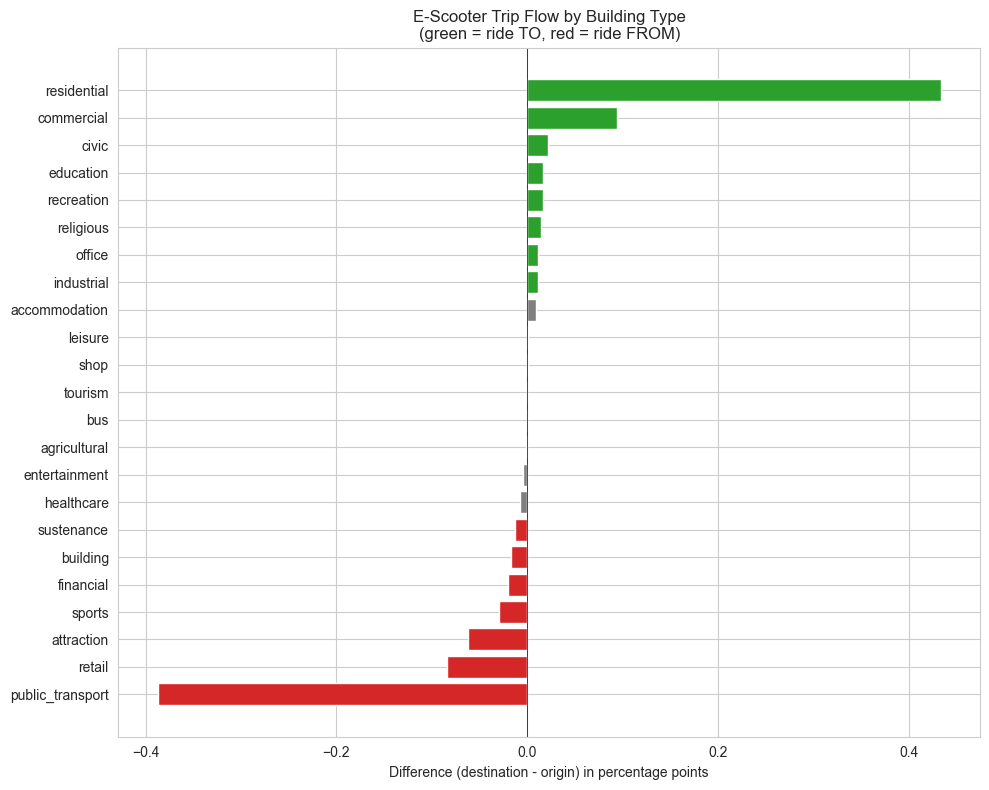

In [10]:
# Visualize origin vs destination differences
fig, ax = plt.subplots(figsize=(10, 8))

od_sorted = od_comparison.sort_values('diff_pp')
colors = ['#d62728' if x < -0.01 else '#2ca02c' if x > 0.01 else '#7f7f7f' 
          for x in od_sorted['diff_pp']]

ax.barh(od_sorted.index, od_sorted['diff_pp'], color=colors)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.set_xlabel('Difference (destination - origin) in percentage points')
ax.set_title('E-Scooter Trip Flow by Building Type\n(green = ride TO, red = ride FROM)')

plt.tight_layout()
plt.show()

In [11]:
# Compute flow by time phase and day type
TIME_PHASES = ['6-14', '14-22', '22-6']

results_weekday = {}
results_weekend = {}

for phase in TIME_PHASES:
    for day_type in ['Weekday', 'Weekend']:
        phase_trips = trips[(trips['time_phase'] == phase) & (trips['day_type'] == day_type)]
        if len(phase_trips) < 100:
            continue
        
        origin = row_proportions.loc[phase_trips['d_id'].values][available_classes].mean()
        dest = row_proportions.loc[phase_trips['f_id'].values][available_classes].mean()
        flow = (dest - origin) * 100
        
        if day_type == 'Weekday':
            results_weekday[phase] = flow
        else:
            results_weekend[phase] = flow

flow_weekday = pd.DataFrame(results_weekday)
flow_weekend = pd.DataFrame(results_weekend)

# Combine into single DataFrame for side-by-side comparison
flow_combined = pd.concat([flow_weekday, flow_weekend], axis=1, keys=['Weekday', 'Weekend'])
print('Flow by time phase (dest - origin, percentage points):')
print(flow_combined.round(2))

Flow by time phase (dest - origin, percentage points):
                 Weekday             Weekend             
                    6-14 14-22  22-6    6-14 14-22   22-6
class                                                    
residential       -10.52  5.17  8.71  -10.11  1.73  12.87
office              0.16 -0.05 -0.08    0.08  0.00  -0.13
commercial          2.32 -0.99 -1.11    1.27 -0.06  -1.86
industrial          0.63 -0.46  0.12    0.16 -0.06  -0.11
public_transport    1.00 -1.12 -1.07    1.87 -0.80  -2.28
retail              1.71 -0.62 -2.15    2.39 -0.22  -3.10
sustenance          0.84 -0.11 -1.49    1.19  0.19  -2.05
healthcare          0.69 -0.46 -0.13    0.40 -0.15  -0.31
education           1.55 -0.77 -0.66    0.26 -0.25  -0.47
recreation         -0.28  0.15  0.18   -0.30  0.01   0.51
entertainment       0.16 -0.01 -0.31    0.18  0.06  -0.43
sports             -0.05  0.03 -0.31    0.50 -0.18  -0.01
attraction          0.87 -0.47 -0.79    1.14 -0.22  -1.30


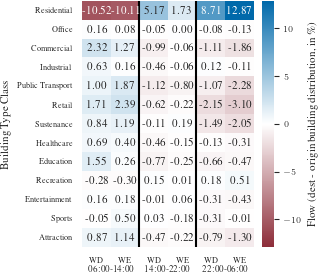

Saved: drive_intention_heatmap.pdf, drive_intention_heatmap.png


In [ ]:
# Combined heatmap - ICML publication format
from tueplots import bundles
from tueplots.constants.color import rgb
from matplotlib.colors import LinearSegmentedColormap

plt.rcParams.update(bundles.icml2024(column="half", nrows=1.4, ncols=1))
tue_cmap = LinearSegmentedColormap.from_list('tue_diverging', 
    [rgb.tue_red, 'white', rgb.tue_blue])

combined = pd.DataFrame({
    'WD': flow_weekday['6-14'],
    'WE': flow_weekend['6-14'],
    'WD ': flow_weekday['14-22'],
    'WE ': flow_weekend['14-22'],
    'WD  ': flow_weekday['22-6'],
    'WE  ': flow_weekend['22-6']
})

combined.index = combined.index.str.replace('_', ' ').str.title()

vmin = combined.min().min()
vmax = combined.max().max()
abs_max = max(abs(vmin), abs(vmax), 0.5)

fig, ax = plt.subplots(layout='constrained')

sns.heatmap(combined, cmap=tue_cmap, center=0, annot=True, fmt='.2f',
            cbar_kws={'label': 'Flow (dest - origin building distribution, in \\%)'}, 
            ax=ax, vmin=-abs_max, vmax=abs_max)

ax.axvline(x=2, color='black', linewidth=1.5)
ax.axvline(x=4, color='black', linewidth=1.5)

n_rows = len(combined)
ax.text(1, n_rows + 1.3, '06:00-14:00', ha='center', fontsize="small", fontweight='bold')
ax.text(3, n_rows + 1.3, '14:00-22:00', ha='center', fontsize="small", fontweight='bold')
ax.text(5, n_rows + 1.3, '22:00-06:00', ha='center', fontsize="small", fontweight='bold')

ax.set_ylabel('Building Type Class')
ax.set_xlabel('')

plt.savefig('drive_intention_heatmap.pdf', bbox_inches='tight')
plt.savefig('drive_intention_heatmap.png', bbox_inches='tight', dpi=300)
plt.show()

print("Saved: drive_intention_heatmap.pdf, drive_intention_heatmap.png")